# NN & CNN
In this laboratory we will be looking at Fully Connected Neural Networks and Convolutional Neural Networks using Pytorch.

Make sure to change the Colab Runtime to GPU for this laboratory.

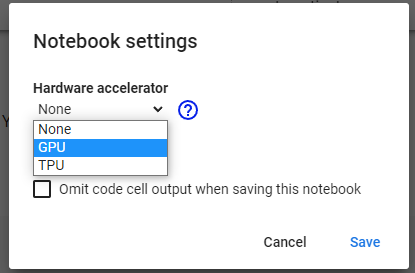

# Load and Visualize the [Data](https://pytorch.org/vision/stable/datasets.html) - [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database)
Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the batch_size if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [1]:
# import libraries
import torch
import numpy as np
cuda = torch.device('cuda')
import statistics

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

valid_transform = train_transform

train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, transform=valid_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 242729684.29it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100194949.40it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48309499.97it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1357939.18it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [3]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

### Visualize a Batch of Training Data
The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

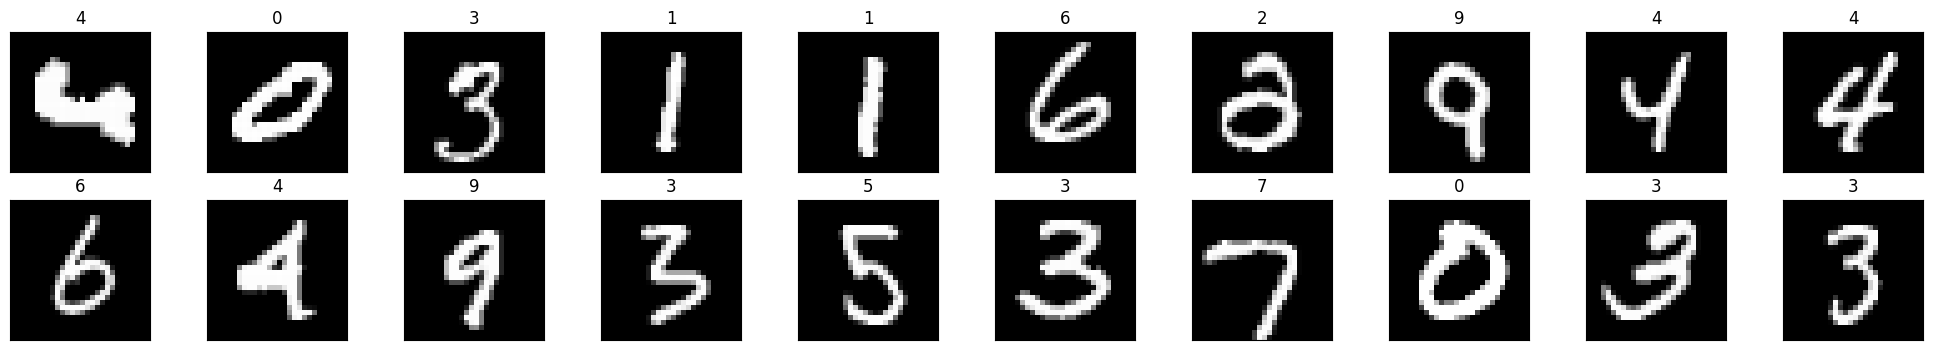

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images - 20 images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels for 20 images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

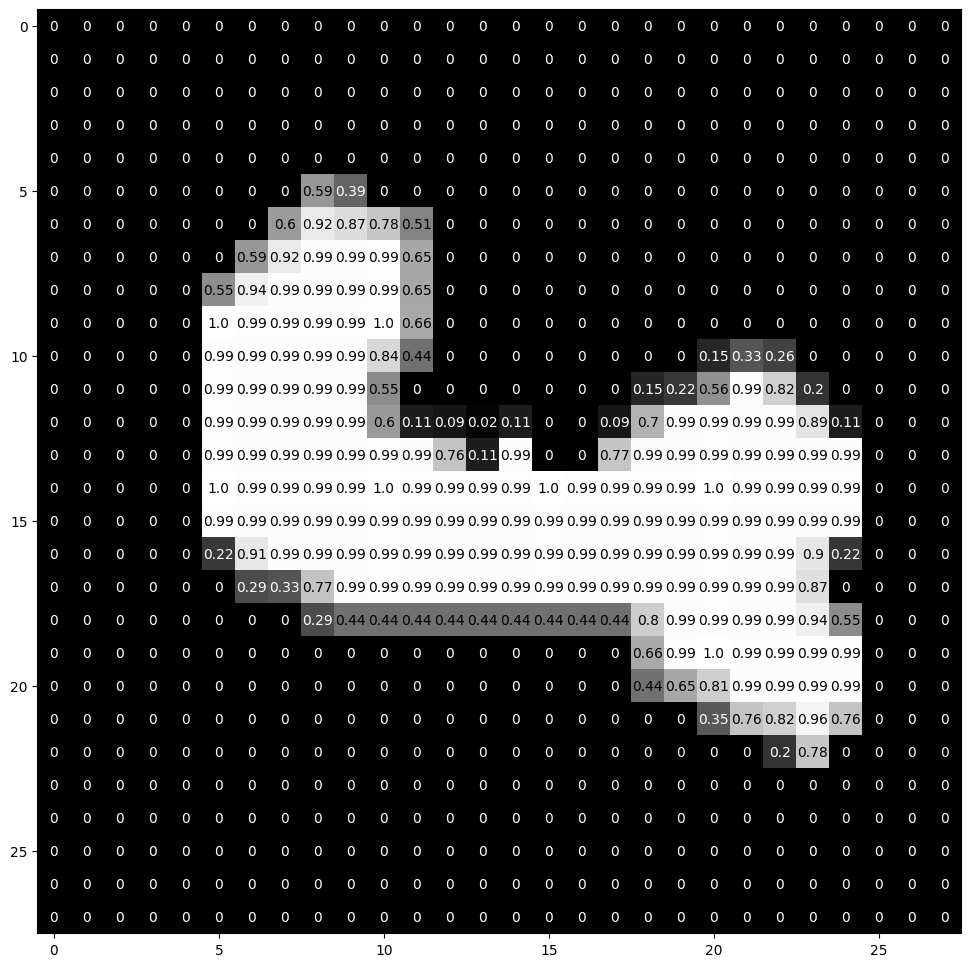

In [5]:
img = np.squeeze(images[0]) # Take the 1st image from the dataset

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define the [Network Architecture](https://pytorch.org/docs/stable/nn.html)
The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.



### Simple Neural Network

We will start with the basic example of a shallow NN: an input layer, two hidden layers and the output layer. We'll use dropout to avoid overfitting.

Each MNIST training example consists of a 28x28 pixels image in grayscale (1 channel), that is turned into a 784-elements vector. The input layer has 784 neurons, we have a hidden layer of 64 neurons and a second hidden layer of 32 neurons. The output layer has 1 neuron for each one of the classes, in this case 10 neurons (10 digits - 0, 1 2, 3, etc).

To implement our neural network, we create the class **BasicNN** and inherit the methods and properties from the Module class (**nn.Module**):

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class BasicNN(nn.Module):

    def __init__(self, input_size, num_classes):

        super(BasicNN, self).__init__()
        # number of hidden nodes in each layer
        hidden_size_1 = 64
        hidden_size_2 = 32

        # linear layer (784 -> hidden_size_1)
        self.fc1 = nn.Linear(input_size, hidden_size_1)

        # linear layer (hidden_size_1 -> hidden_size_2)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)

        # linear layer (hidden_size_2 -> num_classes)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.drop = nn.Dropout(0.2)



    def forward(self, x):
        # flatten image input
        x = x.reshape(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.drop(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.drop(x)
        # add output layer
        x = self.fc3(x)
        return x


# initialize the NN
cuda = torch.device('cuda')
model = BasicNN(input_size=28 * 28, num_classes=10)
model.to(cuda)
print(model)

BasicNN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


### Train the Network
The steps for training/learning from a batch of data are described in the comments below:

* Clear the gradients of all optimized variables
* Forward pass: compute predicted outputs by passing inputs to the model
* Calculate the loss
* Backward pass: compute gradient of the loss with respect to model parameters
* Perform a single optimization step (update weights)
* Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [7]:
def train(model, loss_fn, optimizer):

    # https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train
    # set the module in training mode
    model.train()

    train_batch_losses = []

    for batch, labels in train_loader:

        #send the training data to the GPU
        batch = batch.to(cuda)
        labels = labels.to(cuda)

        #set all gradient to zero
        optimizer.zero_grad()

        #forward propagation
        y_pred = model(batch)

        #calculate loss
        loss = loss_fn(y_pred, labels)

        #backpropagation
        loss.backward()

        #update the parameters (weights and biases)
        optimizer.step()

        train_batch_losses.append(float(loss))

        mean_loss = statistics.mean(train_batch_losses)

    return mean_loss

In [8]:
def validate(model, loss_fn, optimizer):

    # set the model in validation mode
    model.eval()

    # save predictions for later
    predictions = []

    # stop tracking the parameters for backpropagation
    with torch.no_grad():

        validation_batch_losses = []

        for batch, labels in valid_loader:

            # send the validation data to the GPU
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            # forward propagation
            labels_pred = model(batch)

            # calculate the loss
            loss = loss_fn(labels_pred, labels)

            validation_batch_losses.append(float(loss))

            mean_loss = statistics.mean(validation_batch_losses)

    return mean_loss



In [9]:
def accuracy(model, loader):
    correct = 0
    total = 0

    # set the model in validation mode to deactivate the dropout layer
    model.eval()

    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)

            labels_pred = model(batch)

            _, predicted = torch.max(labels_pred.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            return (100 * correct / total)

In [10]:
def training_stats(train_loss, train_accuracy, val_loss, val_accuracy):
    print(('training loss: {:.3f} '
           'training accuracy: {:.2f}% || '
           'val. loss: {:.3f} '
           'val. accuracy: {:.2f}%').format(train_loss, train_accuracy,
                                            val_loss, val_accuracy))

### Specify [Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](https://pytorch.org/docs/stable/optim.html)
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [11]:
# initialize the NN
cuda = torch.device('cuda')
model = BasicNN(input_size=28 * 28, num_classes=10)
model.to(cuda)

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 10

train_losses = []
valid_losses = []

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)



Epoch number  1
training loss: 2.186 training accuracy: 39.84% || val. loss: 1.927 val. accuracy: 41.80%
Epoch number  2
training loss: 1.583 training accuracy: 75.00% || val. loss: 1.085 val. accuracy: 67.19%
Epoch number  3
training loss: 1.038 training accuracy: 80.47% || val. loss: 0.713 val. accuracy: 78.12%
Epoch number  4
training loss: 0.808 training accuracy: 87.50% || val. loss: 0.555 val. accuracy: 83.59%
Epoch number  5
training loss: 0.683 training accuracy: 86.72% || val. loss: 0.475 val. accuracy: 85.94%
Epoch number  6
training loss: 0.616 training accuracy: 83.59% || val. loss: 0.427 val. accuracy: 87.70%
Epoch number  7
training loss: 0.563 training accuracy: 85.94% || val. loss: 0.394 val. accuracy: 88.87%
Epoch number  8
training loss: 0.524 training accuracy: 86.72% || val. loss: 0.366 val. accuracy: 89.65%
Epoch number  9
training loss: 0.494 training accuracy: 86.72% || val. loss: 0.345 val. accuracy: 90.23%
Epoch number  10
training loss: 0.471 training accuracy

### Visualize Sample Test Results
This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

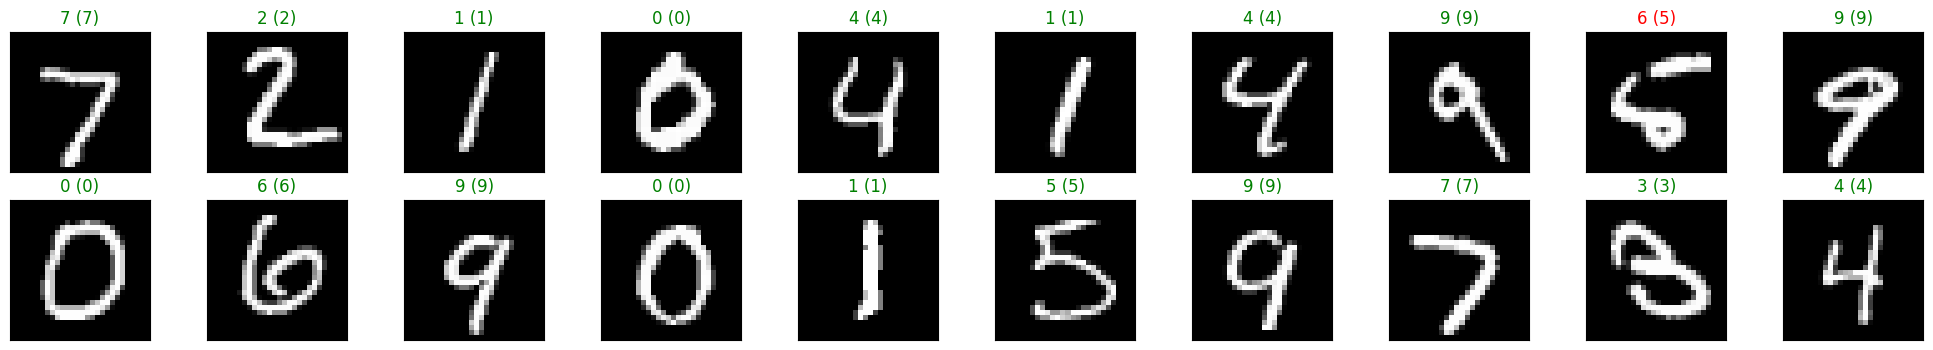

In [12]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# CNNs

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size)
```

num_in_channels is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

num_out_channels is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:



```
torch.nn.Conv2d(3, 32, 3)
```





## A Simple Convolutional Neural Network

In our convnet we'll use the next structure:

*input -> convolution -> pooling-> convolution -> pooling -> convolution* (convolutional base)

*fully connected -> fully connected -> output*

In [13]:
class BasicCNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # for grayscale (e.g. 28 x 28 x 1) image inputs we have 1 input channel
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3*3*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Input Image**

28 x 28 x 1 pixel values

**Convolution #1**

32 kernels of 3x3; *Width/Height:* (28 - 3 + 2x0) / 1 + 1 = 26; *Output dimensions:* (32, 26, 26)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (26 - 2) / 2 + 1 = 13; *Output dimensions:* (32, 13, 13)

**Convolution #2**

64 kernels of 3x3; *Width/Height:* (13 - 3 + 2x0) / 1 + 1 = 11; *Output dimensions:* (64, 11, 11)

**Max Pooling #2**

filter size = 2, stride = 2; *Width/Height:* (11 - 2) / 2 + 1 = 5; *Output dimensions:* (64, 5, 5)

**Convolution #3**

64 kernels of 3x3; *Width/Height:* (5 - 3 + 2x0) / 1 + 1 = 3; *Output dimensions:* (64, 3, 3)

So at the end of the last convolutional layer we get a tensor of dimension (64, 3, 3). And since now we are going to feed it to out fully connected classifier, we need to convert it into a vector, and for that we use the reshape method:



```
x = x.reshape(-1, 3*3*64)
```

### Useful output size calculation
**Convolution & Pooling**

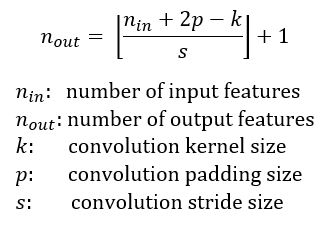

In [14]:
cuda = torch.device('cuda')

model = BasicCNN(1, 10)
model.to(cuda)

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

train_losses = []
valid_losses = []

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)



Epoch number  1
training loss: 0.653 training accuracy: 90.62% || val. loss: 0.216 val. accuracy: 93.75%
Epoch number  2
training loss: 0.116 training accuracy: 96.09% || val. loss: 0.072 val. accuracy: 97.66%
Epoch number  3
training loss: 0.077 training accuracy: 100.00% || val. loss: 0.053 val. accuracy: 98.83%
Epoch number  4
training loss: 0.058 training accuracy: 99.22% || val. loss: 0.047 val. accuracy: 98.63%
Epoch number  5
training loss: 0.047 training accuracy: 97.66% || val. loss: 0.056 val. accuracy: 98.44%
Epoch number  6
training loss: 0.039 training accuracy: 98.44% || val. loss: 0.039 val. accuracy: 99.02%
Epoch number  7
training loss: 0.035 training accuracy: 99.22% || val. loss: 0.065 val. accuracy: 97.07%
Epoch number  8
training loss: 0.030 training accuracy: 100.00% || val. loss: 0.035 val. accuracy: 98.44%
Epoch number  9
training loss: 0.026 training accuracy: 97.66% || val. loss: 0.041 val. accuracy: 98.83%
Epoch number  10
training loss: 0.023 training accura

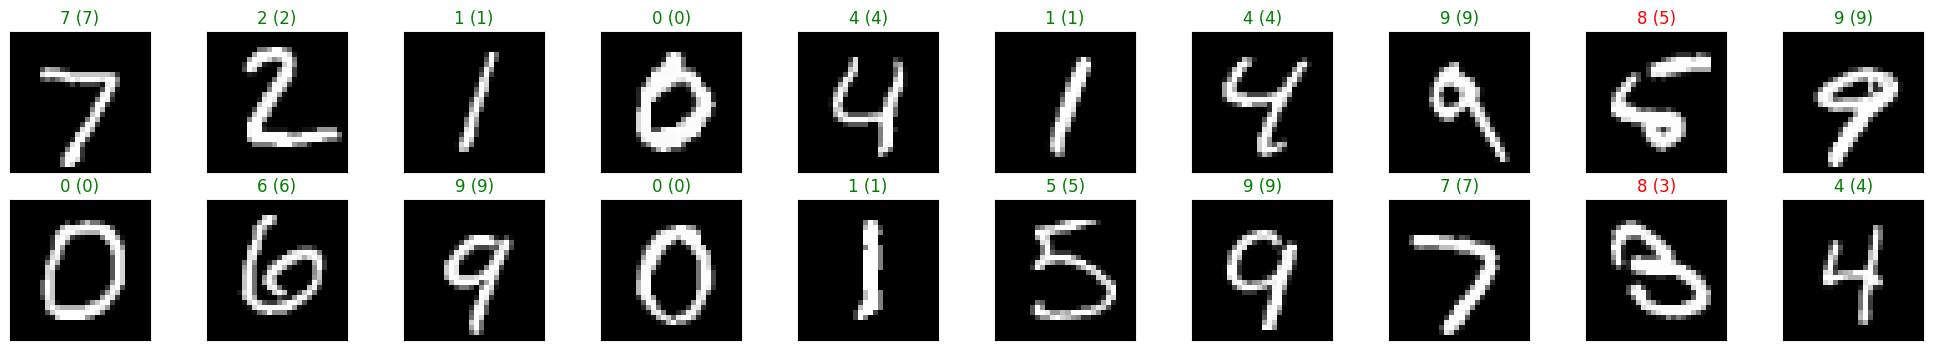

In [16]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Classifying [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10) dataset using CNNs


In [17]:
from torchvision.datasets import CIFAR10

dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = CIFAR10('./cifar10', train=True, download=True, transform=dataset_transform)
valid_set = CIFAR10('./cifar10', train=False, download=True, transform=dataset_transform)

print(train_set.data.shape)
print(valid_set.data.shape)

100%|██████████| 170498071/170498071 [00:05<00:00, 29913429.72it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [18]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

In [19]:
class BasicCNN(nn.Module):

    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
import torch.optim as optim

cuda = torch.device('cuda')
model = BasicCNN(3, 10)
model.to(cuda)

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

train_losses = []
valid_losses = []

best_valid_acc = 0

for epoch in range(0, epochs):

    print('Epoch number ', epoch + 1)

    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)
    if best_valid_acc < valid_accuracy:
        best_valid_acc = valid_accuracy

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)
print('Best validation accuracy', best_valid_acc)

Epoch number  1
training loss: 2.140 training accuracy: 23.44% || val. loss: 2.116 val. accuracy: 25.20%
Epoch number  2
training loss: 1.817 training accuracy: 42.97% || val. loss: 1.649 val. accuracy: 41.02%
Epoch number  3
training loss: 1.614 training accuracy: 43.75% || val. loss: 1.531 val. accuracy: 41.80%
Epoch number  4
training loss: 1.445 training accuracy: 47.66% || val. loss: 1.393 val. accuracy: 46.29%
Epoch number  5
training loss: 1.320 training accuracy: 48.44% || val. loss: 1.328 val. accuracy: 53.91%
Epoch number  6
training loss: 1.219 training accuracy: 64.84% || val. loss: 1.171 val. accuracy: 57.81%
Epoch number  7
training loss: 1.134 training accuracy: 68.75% || val. loss: 1.115 val. accuracy: 62.11%
Epoch number  8
training loss: 1.056 training accuracy: 50.00% || val. loss: 1.306 val. accuracy: 52.93%
Epoch number  9
training loss: 0.987 training accuracy: 67.19% || val. loss: 1.111 val. accuracy: 59.57%
Epoch number  10
training loss: 0.931 training accuracy

torch.Size([3, 32, 32])


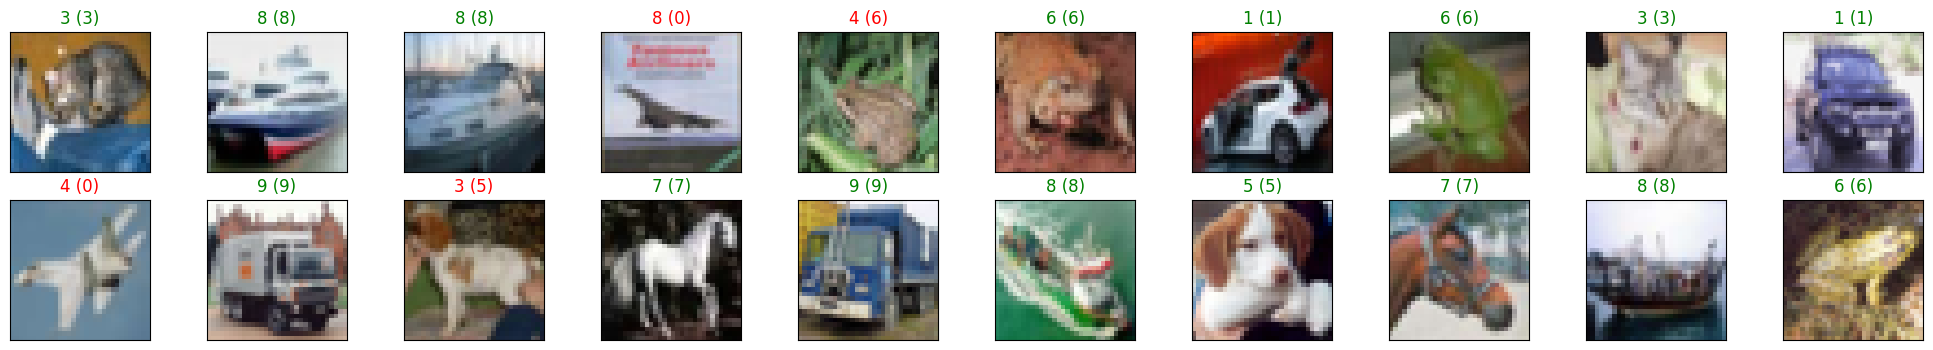

In [21]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = next(dataiter)
images = images.to(cuda)
labels = labels.to(cuda)

print(images[0].shape)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.detach().cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    # img = img.swapaxes(1,2)
    ax.imshow(images[idx].swapaxes(0,2).swapaxes(0,1))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### CIFAR10 classes
```
airplane : 0
automobile : 1
bird : 2
cat : 3
deer : 4
dog : 5
frog : 6
horse : 7
ship : 8
truck : 9
```



# Assignments - TO DO

1. Create a **Fully Connected Neural Network** yourselves that obtains more than **95%** accuracy on **MNIST** data **after 10 epochs**

2. Create a **Convolutional Neural Network** yourselves that obtains more than **67%** accuracy on **CIFAR10** data **after 10 epochs**

Ideas: dropout layers, wider networks, deeper networks, imitating famous network architectures.

In [25]:
"""
CustomDeeperNN:
- utilizes a fully connected neural network architecture where the hidden layers' sizes are defined explicitly:
four hidden layers with sizes 512, 256, 128, and 64
- uses the Adam optimizer with a learning rate of 0.0005
BasicNN
- is a simpler fully connected neural network with three layers where the hidden layers' sizes are predefined as 64 and 32
- uses the SGD optimizer with a learning rate of 0.1
"""

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Device configuration
cuda = torch.device('cuda')

# Define the neural network architecture
class CustomDeeperNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(CustomDeeperNN, self).__init__()
        layers = []
        previous_size = input_size
        for size in hidden_sizes:
            layers.append(nn.Linear(previous_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            previous_size = size
        layers.append(nn.Linear(previous_size, output_size))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Transformations for the MNIST dataset
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

# Load the MNIST dataset
train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, transform=train_transform)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

# Model selection
model = CustomDeeperNN(input_size=28 * 28, hidden_sizes=[512, 256, 128, 64], output_size=10, dropout_rate=0.3)
model.to(cuda)

# Use Adam optimizer with a smaller learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Train for 10 epochs as before
epochs = 10
train_losses = []
valid_losses = []

for epoch in range(epochs):
    train_loss = train(model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracy = accuracy(model, train_loader)

    valid_loss = validate(model, loss_fn, optimizer)
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy(model, valid_loader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {train_loss:.3f} Training accuracy: {train_accuracy:.2f}% || '
          f'Validation loss: {valid_loss:.3f} Validation accuracy: {valid_accuracy:.2f}%')


Epoch 1/10
Training loss: 0.622 Training accuracy: 96.09% || Validation loss: 0.187 Validation accuracy: 94.73%
Epoch 2/10
Training loss: 0.208 Training accuracy: 96.09% || Validation loss: 0.118 Validation accuracy: 97.27%
Epoch 3/10
Training loss: 0.148 Training accuracy: 96.88% || Validation loss: 0.100 Validation accuracy: 97.85%
Epoch 4/10
Training loss: 0.116 Training accuracy: 99.22% || Validation loss: 0.087 Validation accuracy: 98.05%
Epoch 5/10
Training loss: 0.100 Training accuracy: 98.44% || Validation loss: 0.095 Validation accuracy: 97.85%
Epoch 6/10
Training loss: 0.085 Training accuracy: 99.22% || Validation loss: 0.081 Validation accuracy: 98.24%
Epoch 7/10
Training loss: 0.075 Training accuracy: 98.44% || Validation loss: 0.074 Validation accuracy: 98.05%
Epoch 8/10
Training loss: 0.065 Training accuracy: 100.00% || Validation loss: 0.067 Validation accuracy: 98.24%
Epoch 9/10
Training loss: 0.061 Training accuracy: 98.44% || Validation loss: 0.077 Validation accuracy

In [26]:
"""
BASICNN:

Convolutional layers:
- has 3 convolutional layers: self.conv1, self.conv2, and self.conv3 (3x3 kernel, stride: 1 and padding: 0)
- output channels: 32, 64, and 64
Pooling Layers:
- two max-pooling layers: self.pool1 and self.pool2 (2x2 kernel with a stride of 2)
Fully Connected Layers:
- has 2: self.fc1 and self.fc2:
- self.fc1 - input size: 3x3x64; output size: 64
- self.fc2 - input size: 64; output size: 10

IMPROVEDCNN:
Convolutional layers:
- has 2 convolutional layers: self.conv1 and self.conv2 (3x3 kernel, stride: 1, padding: 1)
- output channels: 32 and 64
Pooling Layers:
- uses max-pooling through self.pool after each convolutional layer (2x2 kernel and a stride of 2)
Fully Connected Layers:
- has 2: self.fc1 and self.fc2:
- self.fc1 - input size: 64x8x8; output size: 512
- self.fc2 - input size: 512; output size: 10
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = CIFAR10(root='./cifar10', train=True, download=False, transform=transform)
valid_set = CIFAR10(root='./cifar10', train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, shuffle=False)

# Improved CNN architecture
class ImprovedCNN(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, X):
        x = self.pool(nn.functional.relu(self.conv1(X)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedCNN(3, 10).to(cuda)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

def accuracy(loader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(cuda), data[1].to(cuda)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(cuda), data[1].to(cuda)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = accuracy(train_loader)
    valid_accuracy = accuracy(valid_loader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training loss: {running_loss / len(train_loader):.3f} Training accuracy: {train_accuracy:.2f}% || '
          f'Validation accuracy: {valid_accuracy:.2f}%')

Epoch 1/10
Training loss: 1.685 Training accuracy: 52.53% || Validation accuracy: 52.32%
Epoch 2/10
Training loss: 1.221 Training accuracy: 59.43% || Validation accuracy: 57.85%
Epoch 3/10
Training loss: 1.028 Training accuracy: 68.87% || Validation accuracy: 65.11%
Epoch 4/10
Training loss: 0.879 Training accuracy: 73.49% || Validation accuracy: 68.04%
Epoch 5/10
Training loss: 0.761 Training accuracy: 77.77% || Validation accuracy: 69.90%
Epoch 6/10
Training loss: 0.651 Training accuracy: 81.16% || Validation accuracy: 71.13%
Epoch 7/10
Training loss: 0.550 Training accuracy: 86.30% || Validation accuracy: 71.90%
Epoch 8/10
Training loss: 0.435 Training accuracy: 89.58% || Validation accuracy: 72.47%
Epoch 9/10
Training loss: 0.336 Training accuracy: 92.08% || Validation accuracy: 72.40%
Epoch 10/10
Training loss: 0.241 Training accuracy: 95.47% || Validation accuracy: 72.57%
